In [30]:
import torch
from torch import nn
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pinn.lib import SchrodingerData, SchrodingerModel, get_loss, Util, get_loss
from pinn.bayesian import BayesianFCN
from pinn.train_bayesian_var_inference import train

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [32]:
import os

os.makedirs("Data", exist_ok=True)

import requests

url = "https://github.com/maziarraissi/PINNs/raw/master/main/Data/NLS.mat"
r = requests.get(url)

with open("Data/NLS.mat", "wb") as f:
    f.write(r.content)

print("Downloaded NLS.mat to Data/NLS.mat")

Downloaded NLS.mat to Data/NLS.mat


In [33]:
data = scipy.io.loadmat('Data/NLS.mat')

t_np = data['tt'].flatten()[:,None]
x_np = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)

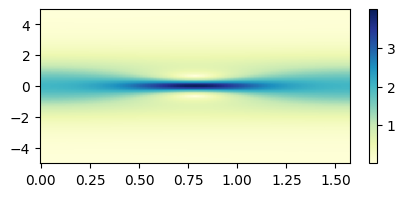

In [34]:
T_np, X_np = np.meshgrid(t_np.squeeze(), x_np.squeeze())

plt.figure(figsize=(5,2))
plt.pcolormesh(T_np, X_np, np.abs(Exact), cmap="YlGnBu")
plt.colorbar()
plt.show()

In [35]:
util = Util()
schrodinger_data = SchrodingerData(util,
                                   Exact,
                                   x_np,
                                   n_data=50,
                                   n_boundary=50,
                                   n_collocation=20000,
                                   t_bound=[0, torch.pi / 2],
                                   x_bound=[-5, 5]
                                  )

In [36]:
clip_norm = 1
beta_scaling = 1e-3
lr = 1e-3

epochs = 1000
schrodinger_model = BayesianFCN(n_input=2,n_layer=3, n_out=2, t_bound=[0, torch.pi / 2],
                                   x_bound=[-5, 5], prior_std=1)
optimizer = torch.optim.Adam(schrodinger_model.parameters(), lr=lr)
schrodinger_model.to(device)

BayesianFCN(
  (first): Sequential(
    (0): BayesianLinear()
    (1): Tanh()
  )
  (hidden): ModuleList(
    (0-2): 3 x Sequential(
      (0): BayesianLinear()
      (1): Tanh()
    )
  )
  (last): BayesianLinear()
)

In [38]:
train(wandb_run=None,     
    clip_norm = 0.5,
    beta_scaling = 5e-5,
    lr = 4e-3,
    mc = 2,
    prior_std = 0.3,
    epochs = 5
)

In [27]:
load = torch.load("weights/Bayesian_variational_inf/schrodinger_model-54000.pt", map_location=device)
schrodinger_model.load_state_dict(
    load["model_state_dict"]
)

<All keys matched successfully>

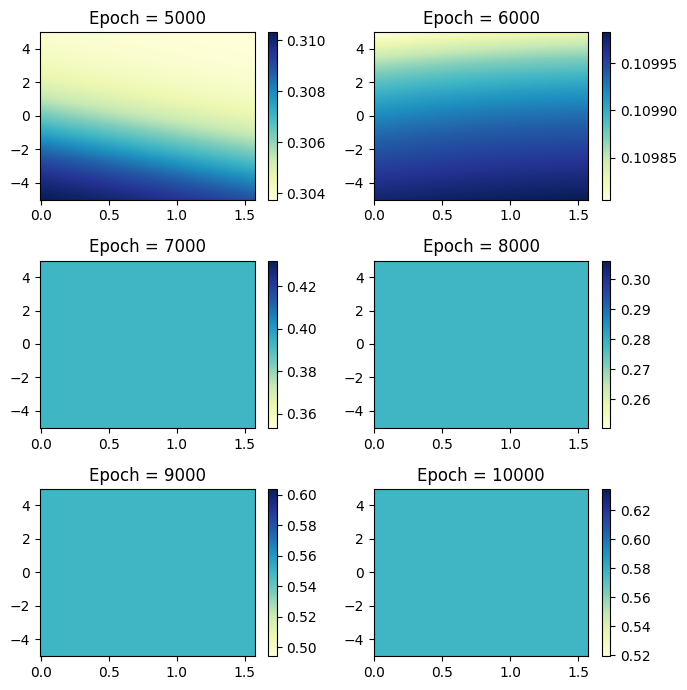

In [28]:
plt.figure(figsize=(7,7))
start = 5000
params = []
for i in range(6):
    epoch = start + i * 1000
    load = torch.load(f"weights/Bayesian_variational_inf/schrodinger_model-{epoch}.pt", map_location=device)
    schrodinger_model.load_state_dict(
        load["model_state_dict"]
    )
    params.append(next(iter(schrodinger_model.parameters()))[0])
    result = schrodinger_model(torch.tensor(X_np.ravel(), dtype=torch.float), torch.tensor(T_np.ravel(), dtype=torch.float), sample=False)
    np_result = np.abs(result.detach().cpu().numpy()[:,1] * 1j + result.detach().cpu().numpy()[:,0])
    
    plt.subplot(3, 2, i + 1)
    plt.title(f"Epoch = {epoch}" )
    plt.pcolormesh(T_np, X_np, np_result.reshape(x_np.shape[0], t_np.shape[0]), cmap="YlGnBu")
    plt.colorbar()

plt.tight_layout()
plt.show()


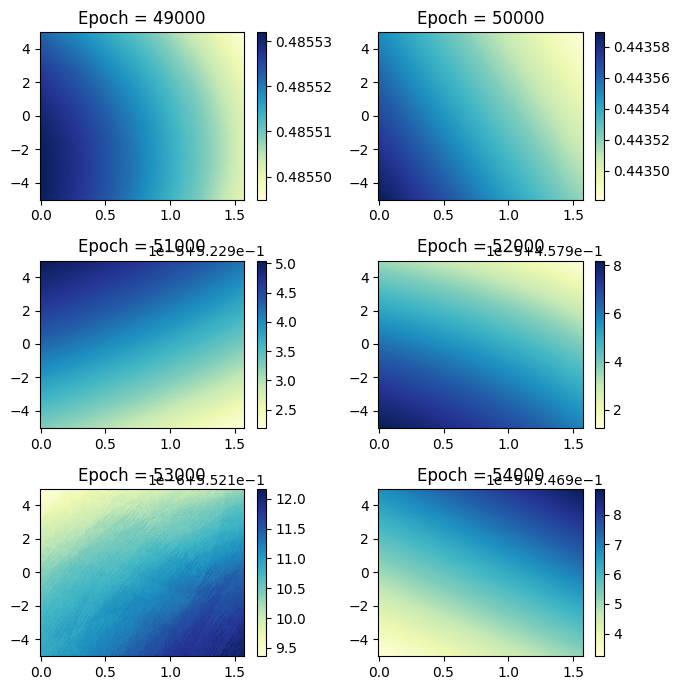

In [29]:
plt.figure(figsize=(7,7))
start = 49000
params = []
for i in range(6):
    epoch = start + i * 1000
    load = torch.load(f"weights/Bayesian_variational_inf/schrodinger_model-{epoch}.pt", map_location=device)
    schrodinger_model.load_state_dict(
        load["model_state_dict"]
    )
    params.append(next(iter(schrodinger_model.parameters()))[0])
    result = schrodinger_model(torch.tensor(X_np.ravel(), dtype=torch.float), torch.tensor(T_np.ravel(), dtype=torch.float), sample=False)
    np_result = np.abs(result.detach().cpu().numpy()[:,1] * 1j + result.detach().cpu().numpy()[:,0])
    
    plt.subplot(3, 2, i + 1)
    plt.title(f"Epoch = {epoch}" )
    plt.pcolormesh(T_np, X_np, np_result.reshape(x_np.shape[0], t_np.shape[0]), cmap="YlGnBu")
    plt.colorbar()

plt.tight_layout()
plt.show()
